# Read & Plot OOI QC Test Flags from NetCDF Files

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Step 1: OOI API to make asynchronous requests 

#### In this example the data are from a GLobal Papa Flanking Mooring CTD deployed at  50  m.

In [ ]:
# API Information
USERNAME = ''
TOKEN = ''
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Instrument Information
site = 'GP03FLMB'
node = 'RIM01'
instrument = '02-CTDMOG061'
method = 'recovered_inst'
stream = 'ctdmo_ghqr_instrument_recovered'

# Create the request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
    'beginDT': '2016-07-01T00:00:00.000Z',
    'endDT': '2017-07-01T00:00:00.000Z',
    'format':'application/netcdf',
    'parameters': '7989,7987,7',
    'include_provenance':'true',
    'include_annotations':'true'
}
# returns some URLs and some other metadata about our request.
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()
#print(data['allURLs'][0])
#print( r.status_code )

### Request completed:
#### the response points to the THREDDS server, which allows for programmatic data access without downloading the entire file.
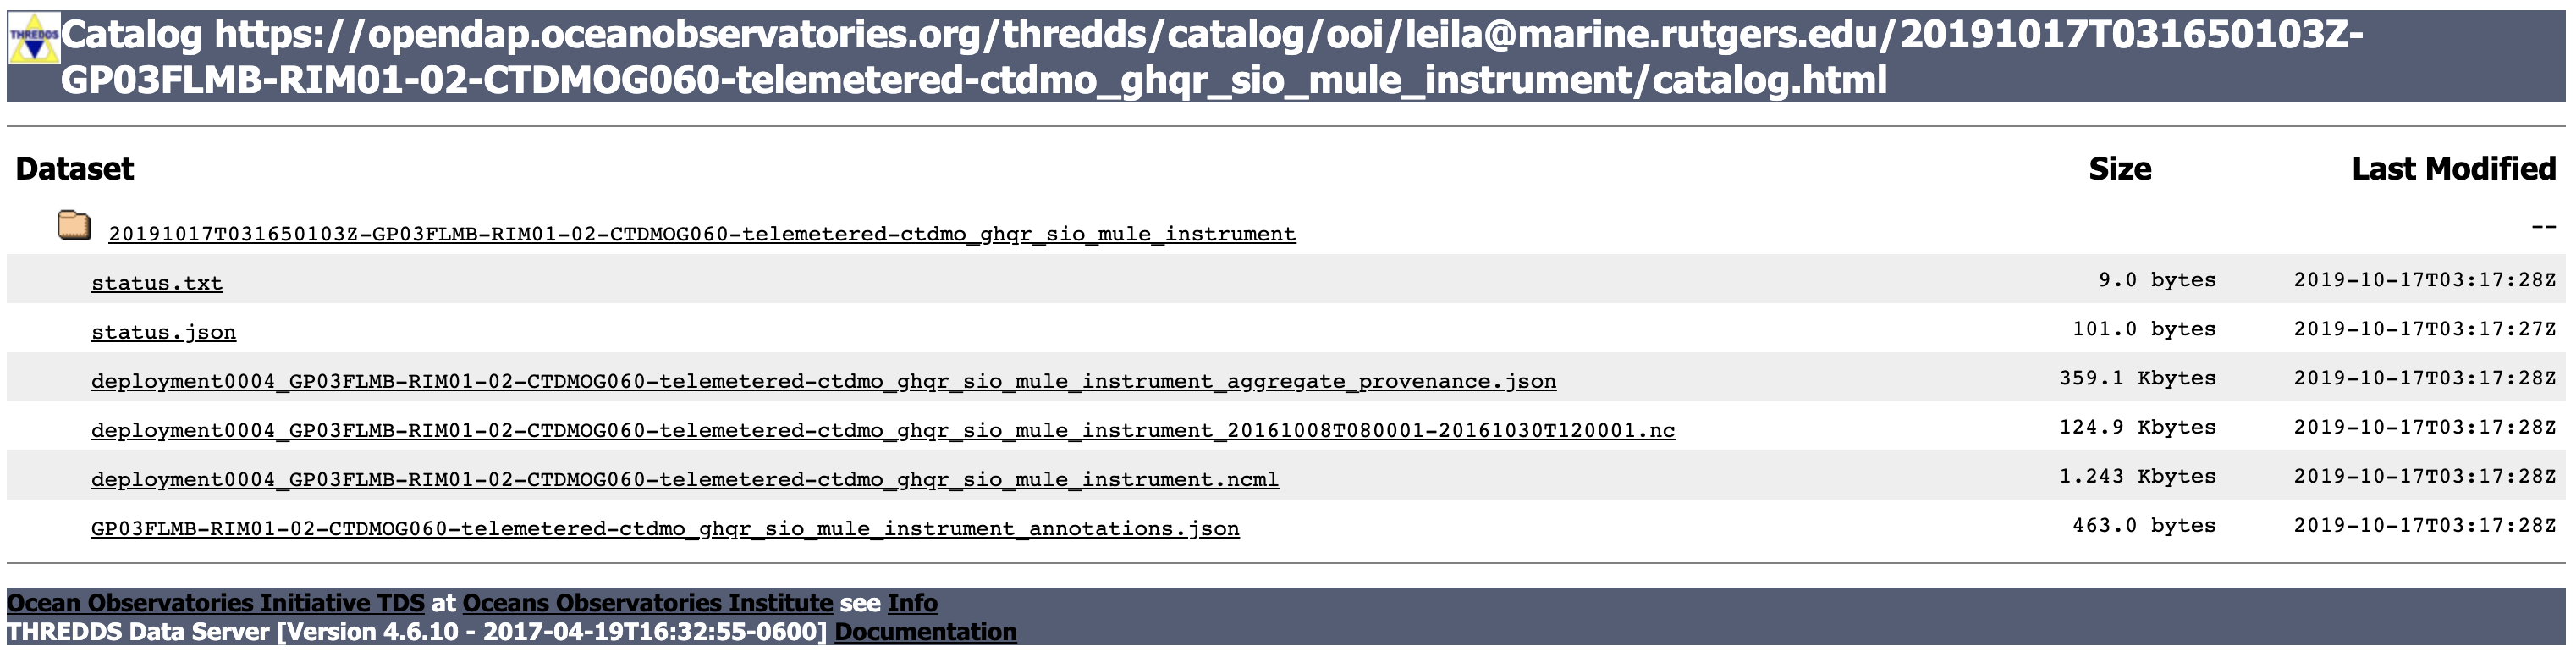

In [2]:
filename = 'deployment0004_GP03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered_20160704T231501-20170630T234501.nc'

In [3]:
ds = xr.open_dataset(filename)

# Step 2: Select pressure parameter 


     obs = 'ctdmo_seawater_pressure'
#### Each parameter comes with two qc variables:
     qc_test_names = 'ctdmo_seawater_pressure_qc_executed' 
     qc_test_flags = 'ctdmo_seawater_pressure_qc_results'

In [5]:
df = ds[['ctdmo_seawater_pressure', 'ctdmo_seawater_pressure_qc_executed', 'ctdmo_seawater_pressure_qc_results','time']].to_dataframe()
# Re-index by time
df = df.set_index(df['time'])
# drop time columns
df = df.drop('time',axis=1)

In [6]:
df.head()

,ctdmo_seawater_pressure,ctdmo_seawater_pressure_qc_executed,ctdmo_seawater_pressure_qc_results
time,,,
2016-07-04 23:15:01,6.408953,29,29
2016-07-04 23:30:01,19.508035,29,29
2016-07-04 23:45:01,93.363346,29,29
2016-07-05 00:00:01,62.972542,29,29
2016-07-05 00:15:01,52.830192,29,29


## QC table

### The QC flags for all tests are put together to produce a single value for each data point.
```
Test name              Bit position
                         15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0
global_range_test         0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
dataqc_localrangetest     0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
dataqc_spiketest          0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
dataqc_polytrendtest      0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
dataqc_stuckvaluetest     0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
dataqc_gradienttest       0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
dataqc_propagateflags     0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
```

 
### So, given a qc_executed value of 29 we can see which tests were run by reversing the process:

In [8]:
np.unpackbits(np.array(29).astype('uint8'))

array([0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8)

#### If you compare this result to the table above you can see that the following tests were executed:

```
global_range_test
dataqc_spiketest
dataqc_polytrendtest
dataqc_stuckvaluetest
```


## Step 3: Create Pass/Fail results for each test run
#### The function below creates new booleans variables for each test run containing the pass/fail results from that test:

In [9]:
i_executed = 'ctdmo_seawater_pressure_qc_executed'
i_results = 'ctdmo_seawater_pressure_qc_results'
def parse_qc(dataframe, i_executed, i_results):
    names = {
        0: 'global_range_test',
        1: 'dataqc_localrangetest',
        2: 'dataqc_spiketest',
        3: 'dataqc_polytrendtest',
        4: 'dataqc_stuckvaluetest',
        5: 'dataqc_gradienttest',
        7: 'dataqc_propagateflags',
    }
    # Just in case a different set of tests were run on some datapoint
    # *this should never happen*
    executed = np.bitwise_or.reduce(dataframe[i_executed].values)
    executed_bits = np.unpackbits(executed.astype('uint8'))
    for index, value in enumerate(executed_bits[::-1]):
        if value:
            name = names.get(index)
            mask = 2**index
            values = (dataframe[i_results].values & mask) > 0
            dataframe[name] = values
    dataframe.drop([i_executed, i_results], axis=1, inplace=True)

In [10]:
parse_qc(df, i_executed, i_results)

In [11]:
df.head()

,ctdmo_seawater_pressure,global_range_test,dataqc_spiketest,dataqc_polytrendtest,dataqc_stuckvaluetest
time,,,,,
2016-07-04 23:15:01,6.408953,True,True,True,True
2016-07-04 23:30:01,19.508035,True,True,True,True
2016-07-04 23:45:01,93.363346,True,True,True,True
2016-07-05 00:00:01,62.972542,True,True,True,True
2016-07-05 00:15:01,52.830192,True,True,True,True


### Note:
##### 1. Develop and create automated test for measurements √
##### 3. Establish a data flag system or a data annotation service to communicate results √

## Step 4: Plot Data

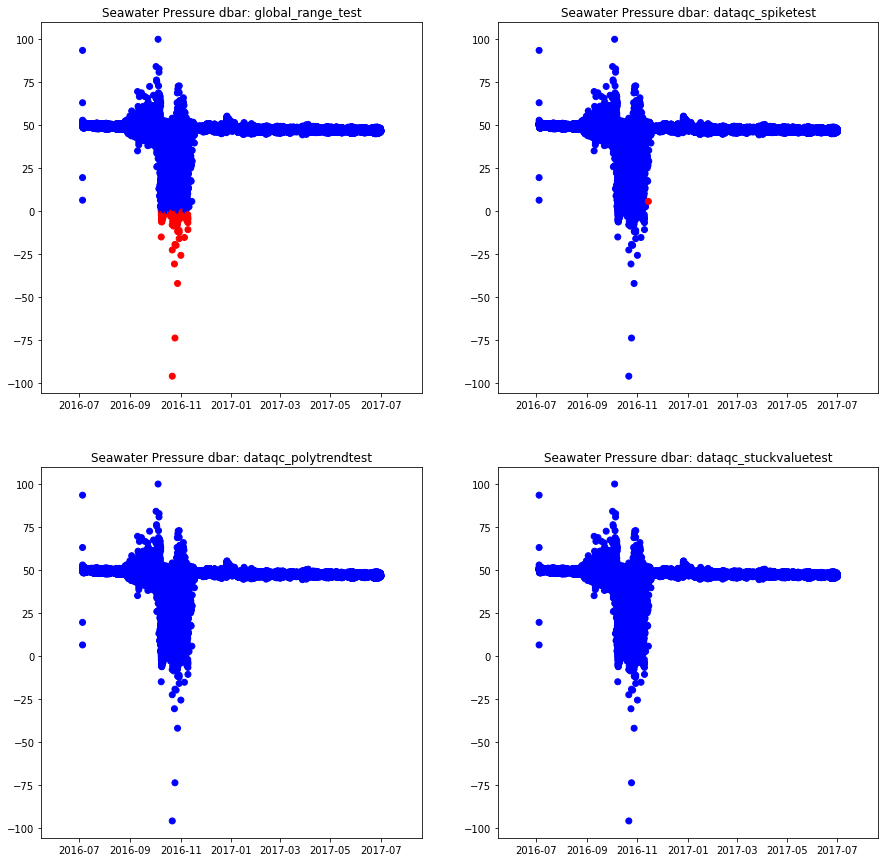

In [12]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

for x in [1,2,3,4]:
    col_name = df.columns[x]
    colors_i = ['b' if flag==True else 'r' for flag in df[col_name]]
    plt.subplot(2, 2, x)
    plt.scatter(df.index,df['ctdmo_seawater_pressure'], color=colors_i)
    plt.title('Seawater Pressure dbar: '+df.columns[x])

## Remark:
#### The global range test and the spike test do not highlight the issue with this instrument. This should be investigated and annotated in the system.

### Note:
#### 2. Examine test results to identify and address the errors and omissions X

#####  OOI - Quality control algorithm tables: https://github.com/ooi-integration/qc-lookup
##### data_qc_global_range_values
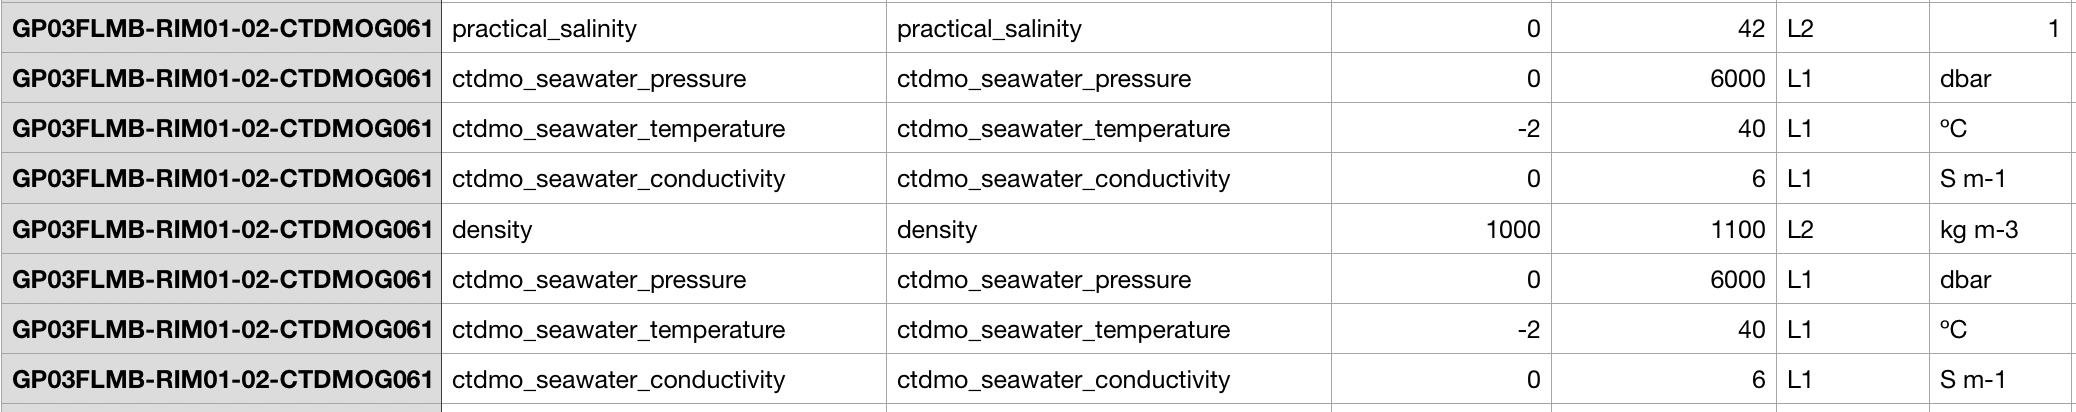

##### data_qc_spike_test_values
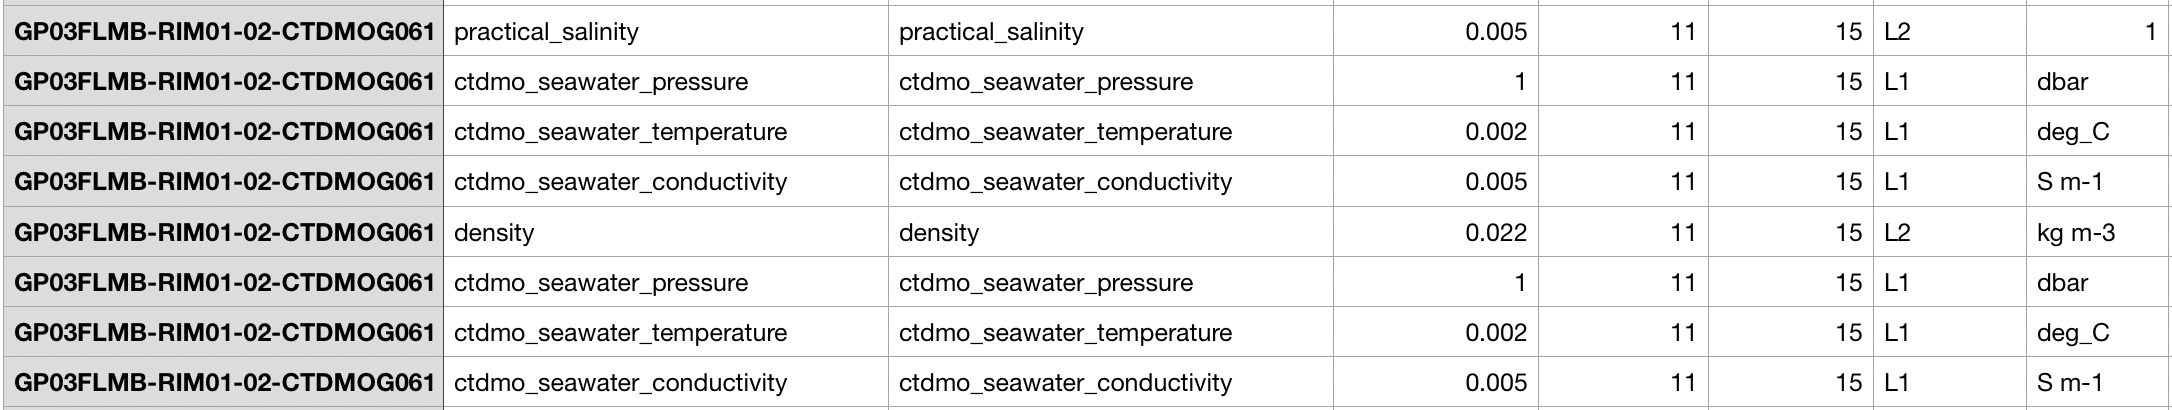

### Data Provenance
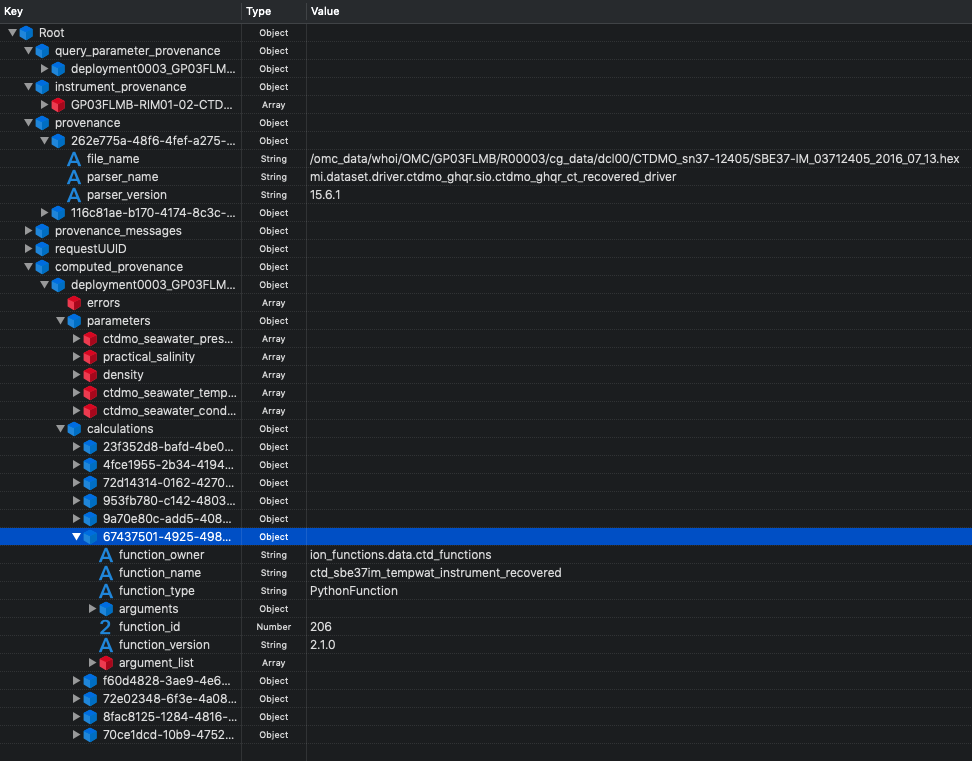

### Data Annotation
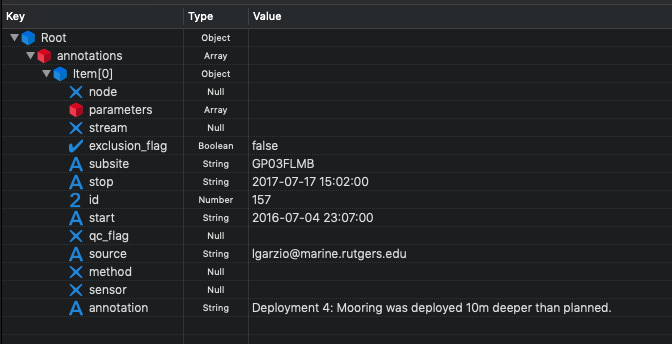

### Note:
#### 4. Document all QC activities to ensure data correctness, completeness, and reuse X

# END